### Import Libraries

In [1]:
from wrapper_functions_CAR import *
tf.config.run_functions_eagerly(True)
np.random.seed(10)

C:\Users\Admin-Dell\anaconda3\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
C:\Users\Admin-Dell\anaconda3\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


TensorFlow version: 2.11.0. Expected: 2.7.0
TensorFlow Probability version: 0.19.0. Expected: 0.15.0


### Create the fake data



In [2]:
training2010 = pd.read_csv('../data/merged_wp_census_data2_081122.csv')
county_adj = pd.read_csv('../data/countyadj2.csv', index_col = 0)
models = ['pep', 'worldpop']

In [3]:
data_NY, adj_NY = subset_data_by_state(training2010, county_adj, 'New York', 'NY')

# Default Configs

In [4]:
# MCMC configs.
mcmc_step_size=0.1 # @param
mcmc_sample_size=500 # @param
mcmc_num_steps=10_000 # @param
mcmc_burnin=2_500 # @param
mcmc_nchain=10 # @param
mcmc_seed=0 # @param

DEFAULT_MCMC_CONFIG = dict(step_size=mcmc_step_size, 
                           num_steps=mcmc_sample_size, 
                           burnin=mcmc_burnin, 
                           nchain=mcmc_nchain, 
                           seed=mcmc_seed)

#### Running with HMC

In [57]:
mcmc_config = DEFAULT_MCMC_CONFIG.copy()
mcmc_config.update(dict(burnin = 0, num_steps = 2500, nchain = 5, 
                        kernel_type = 'nuts', step_adaptor_type = 'simple'))
mcmc_config

{'step_size': 0.1,
 'num_steps': 2500,
 'burnin': 0,
 'nchain': 5,
 'seed': 0,
 'kernel_type': 'nuts',
 'step_adaptor_type': 'simple'}

In [58]:
phi_true, u_true, data = simulate_data(data_NY[:],
                                       adj_NY[:], 
                                       sim_numbers = False,
                                       scale_down = 1,
                                       poisson_noise = False,
                                       pivot = -1, 
                                       one_model = False, 
                                       models = models)

fixing tau2 and rho


In [59]:
t0 = time.perf_counter()
CAR_samples, chain_samples, sampler_stat = run_mcmc_CAR(data = data[:],
                                                        adjacency = adj_NY[:],
                                                        pivot = -1,
                                                        models = models,                                                        
                                                        debug_mode = True,
                                                        num_adaptation_steps = 2000,
                                                        #num_adaptation_steps = 0,
                                                        **mcmc_config)  
print(time.perf_counter() - t0)

fixing tau2 and rho
when adding in tau2 and rho, need to update the likelihood function and confirm gradient works!
running MAP
0
-1215571492.319118...1000
-1215571552.0010026...2000
-1215571595.4819148...3000
-1215571624.7316778...4000
-1215571643.5807383...5000
-1215571655.6836777...6000
-1215571663.5489168...7000
-1215571668.688218...8000
-1215571672.1340094...9000
-1215571674.608571...10000
-1215571676.4350517...11000
-1215571677.6733637...12000
-1215571678.389987...13000
-1215571678.7915437...14000
-1215571679.1520028...15000
-1215571679.6597648...16000
-1215571680.3561666...17000
-1215571681.1851804...18000
-1215571682.068304...19000
-1215571682.9399767...Done.
kernel type is nuts
simple step size
2500
<function run_chain_CAR.<locals>.trace_fn at 0x0000029394AC1040>
no cache clearing
Acceptance Ratio: 0.6812023113647175
1591.7395203


In [28]:
tt = sampler_stat[2]
ss = sampler_stat[3]
tt.numpy().shape, ss
grads = sampler_stat[3].inner_results.accepted_results.grads_target_log_prob
ll = sampler_stat[3].inner_results.accepted_results.target_log_prob

In [60]:
pivot_fit = -1
pivot_DGP = -1
res_dict = {'CAR_samples': CAR_samples,
            'chain_samples': chain_samples, 
            'sampler_stat': sampler_stat,
            'phi_true': phi_true, 
            'u_true': u_true, 
            'data': data, 
            'adjacency': adj_NY,
            'pivot_fit': pivot_fit,
            'pivot_DGP': pivot_DGP, 
            'models': models,
            'mcmc_config': mcmc_config}

Saving and loading Python objects with Pickle

In [62]:
import pickle

# using local data file because these are too big for github
#local_dir = 'C:/Users/nickl/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
local_dir = 'C:/Users/Admin-Dell/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
with open(local_dir + 'CAR_samples_NY_n10000_hmc_realdata_2models_July122023.pickle', 'wb') as results_file:
  # pickle.dump([res_dict, mcmc_config], results_file)
  pickle.dump(res_dict, results_file)

### Loading results and analyzing

In [75]:
local_dir = 'C:/Users/Admin-Dell/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
#local_dir = 'C:/Users/nickl/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
file = local_dir + 'CAR_samples_NY_n10000_simdata_2models_July122023.pickle'
with open(file, "rb") as input_file:
     #CAR_samples, chain_samples, sampler_stat, mcmc_config, phi_true, u_true, data_sub = pickle.load(input_file)
    res_dict = pickle.load(input_file)
res_dict.keys()

dict_keys(['CAR_samples', 'chain_samples', 'sampler_stat', 'phi_true', 'u_true', 'data', 'adjacency', 'pivot_fit', 'pivot_DGP', 'models', 'mcmc_config'])

## Getting the gradient and likelihood values

In [76]:
target_log_prob_fn = get_log_prob_from_results(res_dict)
res_100 = pull_gradient_wrapper(res_dict['chain_samples'], target_log_prob_fn, skip_val = 1, max_iter =  100, step_sizes = res_dict['sampler_stat'][0].numpy())
res_full = pull_gradient_wrapper(res_dict['chain_samples'], target_log_prob_fn, skip_val = 100, step_sizes = res_dict['sampler_stat'][0].numpy())
res_100

fixing tau2 and rho
when adding in tau2 and rho, need to update the likelihood function and confirm gradient works!


,iter,log_posterior,mean_abs_grad,step_size,logL_CAR_prior,logL_det,log_likelihood
0,0.0,111639.879465,1.224831,0.235309,-306.192111,461.630202,111484.441373
1,1.0,111639.879465,1.224831,0.235309,-306.192111,461.630202,111484.441373
2,2.0,111639.879465,1.224831,0.235309,-306.192111,461.630202,111484.441373
3,3.0,111652.268132,1.201079,0.235309,-293.941982,461.630202,111484.579912
4,4.0,111658.125862,1.174406,0.235309,-284.819808,461.630202,111481.315468
...,...,...,...,...,...,...,...
95,95.0,111655.049495,1.181513,0.235309,-293.260013,461.630202,111486.679306
96,96.0,111655.049495,1.181513,0.235309,-293.260013,461.630202,111486.679306
97,97.0,111655.049495,1.181513,0.235309,-293.260013,461.630202,111486.679306
98,98.0,111623.673659,1.259068,0.235309,-324.025444,461.630202,111486.068901


In [77]:
_, posteriors, gradients, _, _, _ = pull_gradient(res_dict['chain_samples'], target_log_prob_fn, skip_val = 1)
np.sum(np.abs(gradients - grads[0])), np.sum(np.abs(posteriors - ll))

InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [12500,5,62,2] vs. [250,5,62,2] [Op:Sub]

In [ ]:
phi = res_dict['chain_samples'][1000]
_ = gradient_comparison(phi, target_log_prob_fn)

In [ ]:
# making 5 copies of phi_true to test the likelihood
phi_true = tf.constant(np.array([[res_dict['phi_true'].numpy()[0] for i in range(5)]]))
true_vals = pull_gradient(phi_true, target_log_prob_fn)
true_vals[1]

## Plotting MCMC diagnostics

Text(0, 0.5, 'log posterior')

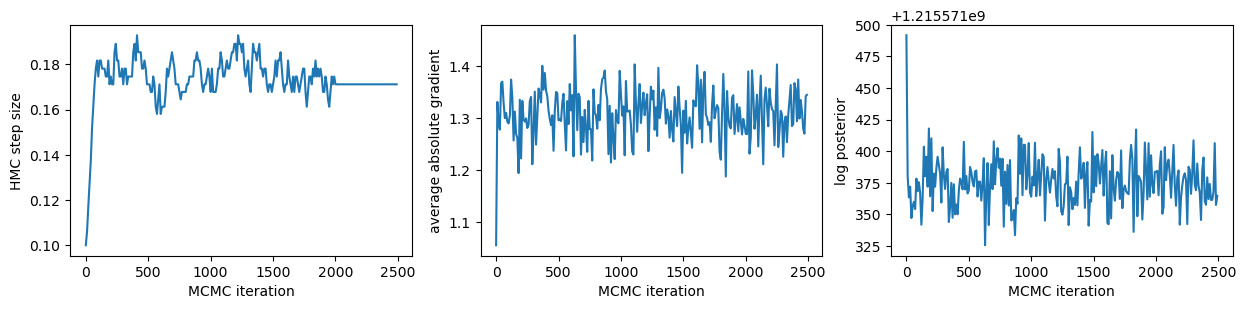

In [72]:
plt.rcParams['figure.figsize'] = [15, 3]
res = res_full

plt.subplot(1, 3, 1)
plt.plot(res['iter'],res['step_size'])
plt.xlabel('MCMC iteration')
plt.ylabel('HMC step size')

plt.subplot(1, 3, 2)
plt.plot(res['iter'],res['mean_abs_grad'])
plt.xlabel('MCMC iteration')
plt.ylabel('average absolute gradient')

plt.subplot(1, 3, 3)
plt.plot(res['iter'],res['log_posterior'])
plt.xlabel('MCMC iteration')
plt.ylabel('log posterior')

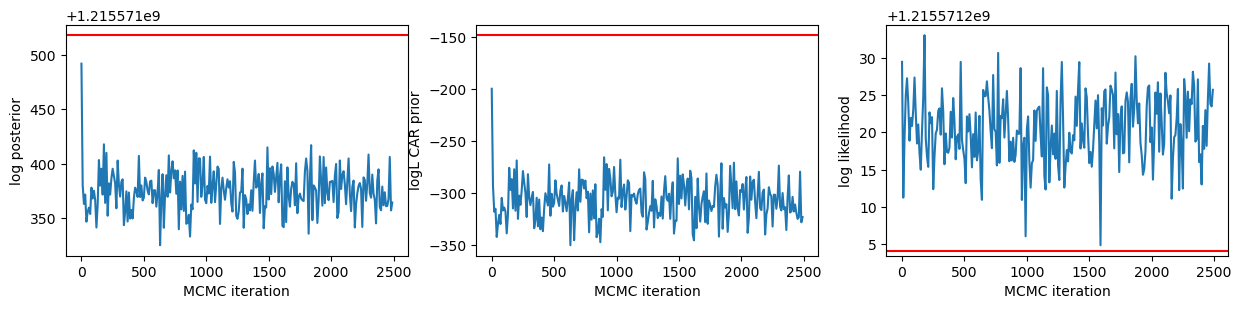

In [73]:
plt.rcParams['figure.figsize'] = [15, 3]
res = res_full

plt.subplot(1, 3, 1)
plt.plot(res['iter'],res['log_posterior'])
plt.xlabel('MCMC iteration')
plt.ylabel('log posterior')
plt.axhline(y = true_vals[1], color = 'r', linestyle = '-')

plt.subplot(1, 3, 2)
plt.plot(res['iter'],res['logL_CAR_prior'])
plt.xlabel('MCMC iteration')
plt.ylabel('logL CAR prior')
plt.axhline(y = true_vals[3], color = 'r', linestyle = '-')

plt.subplot(1, 3, 3)
plt.plot(res['iter'],res['log_likelihood'])
plt.xlabel('MCMC iteration')
plt.ylabel('log likelihood')
plt.axhline(y = true_vals[5], color = 'r', linestyle = '-')

## Getting the rhat and ESS values

In [69]:
u_samples = phi_to_u(res_dict['chain_samples'])
ESS = tfp.mcmc.effective_sample_size(u_samples, cross_chain_dims = 1).numpy()
rhat = tfp.mcmc.potential_scale_reduction(res_dict['chain_samples'], independent_chain_ndims=1).numpy()
print(np.quantile(ESS, [0.5, 0.025, 0.975]))
print(np.quantile(rhat, [0.5, 0.025, 0.975]))

[12500.         6942.8944022 12500.       ]
[0.99980068 0.99964068 1.000799  ]


## Plotting the density of the phis at different parts of the chain


In [ ]:
import seaborn as sns
#plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.figsize'] = [15, 3]
fig = plt.figure()

plt.subplot(1, 3, 1)


sns.set(style="darkgrid")
sns.kdeplot(res_dict['phi_true'].numpy()[0].flatten(), shade=True)
plt.xlabel('')
plt.xlim(-2, 2)
plt.title('true phi')

plt.subplot(1, 3, 2)

sns.set(style="darkgrid")
sns.kdeplot(res_dict['chain_samples'].numpy()[0].flatten(), shade=True)
plt.xlabel('')
plt.xlim(-2, 2)
plt.title('phi from MAP')

plt.subplot(1, 3, 3)

sns.set(style="darkgrid")
sns.kdeplot(res_dict['chain_samples'].numpy()[1000].flatten())
sns.kdeplot(res_dict['chain_samples'].numpy()[3000].flatten())
sns.kdeplot(res_dict['chain_samples'].numpy()[5000].flatten())
sns.kdeplot(res_dict['chain_samples'].numpy()[7000].flatten())
sns.kdeplot(res_dict['chain_samples'].numpy()[9000].flatten())
sns.kdeplot(res_dict['chain_samples'].numpy()[11000].flatten())
sns.kdeplot(res_dict['chain_samples'].numpy()[2000].flatten())
sns.kdeplot(res_dict['chain_samples'].numpy()[4000].flatten())
sns.kdeplot(res_dict['chain_samples'].numpy()[6000].flatten())
sns.kdeplot(res_dict['chain_samples'].numpy()[8000].flatten())
sns.kdeplot(res_dict['chain_samples'].numpy()[10000].flatten())
sns.kdeplot(res_dict['chain_samples'].numpy()[12000].flatten())
plt.xlabel('')
plt.xlim(-2, 2)
plt.title('phi from MCMC sampler')

## Plotting the density of average estimated phi values

In [ ]:
import seaborn as sns
#plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.figsize'] = [15, 3]
fig = plt.figure()
pivot_fit = res_dict['pivot_fit']

## The true u plot
plt.subplot(1, 2, 1)

CAR_df = pd.DataFrame(res_dict['phi_true'][0,:,:], columns = res_dict['models'])
sns.set(style="darkgrid")
sns.kdeplot(CAR_df['worldpop'], shade=True, color="r", label = 'worldpop')
sns.kdeplot(CAR_df["pep"], shade=True, color="b", label = 'pep')
#plt.ylabel(labels[pivot_DGP + 1])
plt.xlabel('')
plt.xlim(-2,2)
plt.title('phi true')

## The estimated u plot
CAR_ensemble_phis = tf.reduce_mean(res_dict['CAR_samples'][0], axis = 2).numpy()
#u = phi_to_u(CAR_ensemble_phis, pivot = res_dict['pivot_fit'])
CAR_df = pd.DataFrame(CAR_ensemble_phis, columns = res_dict['models'])

plt.subplot(1, 2, 2)
sns.set(style="darkgrid")
tt = sns.kdeplot(CAR_df['worldpop'], shade=True, color="r", label = 'worldpop')
tt = sns.kdeplot(CAR_df["pep"], shade=True, color="b", label = 'pep')
#tt = sns.kdeplot(CAR_df["worldpop"], shade=True, color="g", label = 'worldpop')
#plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.xlim(-2,2)
plt.title('Average estimated phi')

plt.legend()
plt.show()

## Plotting the density of u values

In [ ]:
import seaborn as sns
#plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.figsize'] = [15, 3]
fig = plt.figure()
pivot_fit = res_dict['pivot_fit']

## The true u plot
plt.subplot(1, 2, 1)

CAR_df = pd.DataFrame(res_dict['u_true'][0,:,:], columns = res_dict['models'])
sns.set(style="darkgrid")
tt = sns.kdeplot(CAR_df['worldpop'], shade=True, color="r", label = 'worldpop')
tt = sns.kdeplot(CAR_df["pep"], shade=True, color="b", label = 'pep')
#plt.ylabel(labels[pivot_DGP + 1])
plt.xlabel('')
plt.xlim(0,1)
plt.title('u true')

## The estimated u plot
CAR_ensemble_phis = tf.reduce_mean(res_dict['CAR_samples'][0], axis = 2).numpy()
u = phi_to_u(CAR_ensemble_phis, pivot = res_dict['pivot_fit'])
CAR_df = pd.DataFrame(u, columns = res_dict['models'])

plt.subplot(1, 2, 2)
sns.set(style="darkgrid")
tt = sns.kdeplot(CAR_df['worldpop'], shade=True, color="r", label = 'worldpop')
tt = sns.kdeplot(CAR_df["pep"], shade=True, color="b", label = 'pep')
#tt = sns.kdeplot(CAR_df["worldpop"], shade=True, color="g", label = 'worldpop')
#plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.xlim(0,1)
plt.title('estimated u')

plt.legend()
plt.show()

## Plotting scatterplots of the fitted vs true u values and predictions vs true

In [ ]:
plt.rcParams['figure.figsize'] = [15, 6]
fig = plt.figure()

phi = res_dict['CAR_samples'][0]

predictions = np.empty(shape=(phi.shape[0], 
                              phi.shape[2]), 
                       dtype='float64')

u = np.empty(shape = phi.shape, dtype = 'float64')
for i in range(phi.shape[2]):
    u[:,:,i] = phi_to_u(phi[:,:,i], pivot = -1)
    predictions[:,i] = tf.reduce_sum(res_dict['data'][res_dict['models']].values*u[:,:,i], axis = 1)
   # predictions[:,i] = tf.reduce_sum(data_pivot[models].values*u, axis = 1)

y_pred = np.mean(predictions, axis = 1)
    
## Make the u plot    
CAR_df = pd.DataFrame(np.mean(u, axis = 2), columns = res_dict['models'])

plt.subplot(2, 3, 1)
x = np.ndarray.flatten(res_dict['u_true'][0,:,:].numpy())
y = np.ndarray.flatten(CAR_df.values)
plt.scatter(x, y)
plt.xlabel("true u")
plt.ylabel('avg estimated u')

plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

## obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
## add linear regression line to scatterplot 
#plt.plot(x, m*x+b, color = 'red')
## add y = x lin
plt.plot(x, x, color = 'red')

## Make the phi plot
plt.subplot(2, 3, 2)
phi_avg = np.mean(phi, 2)

x = np.ndarray.flatten(res_dict['phi_true'].numpy())
y = np.ndarray.flatten(phi_avg)
plt.scatter(x, y)
plt.xlabel("true phi")
plt.ylabel('avg estimated phi')
plt.plot(x, x, color = 'red')

plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

## Make the predictions plot
plt.subplot(2, 3, 3)

x = res_dict['data']['census']
y = y_pred
#y = y_pred.numpy()
plt.scatter(x, y)
plt.xlabel("true census values")
plt.ylabel("predicted census values")

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y.astype('float64'), 1)

plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
#ax.set_xscale("log")
#ax.set_yscale("log")

## obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
## add linear regression line to scatterplot 
#plt.plot(x, m*x+b, color = 'red')
## add y = x line
plt.plot(x, x, color = 'red')


## Make the phi plots
plt.subplot(2, 3, 4)

x = np.ndarray.flatten(res_dict['phi_true'].numpy())
y = np.ndarray.flatten(phi.numpy()[:,:,0])
plt.scatter(x, y)
plt.xlabel("true phi")
plt.ylabel('phi at t = 0')
plt.plot(x, x, color = 'red')

plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.subplot(2, 3, 5)

x = np.ndarray.flatten(res_dict['phi_true'].numpy())
y = np.ndarray.flatten(phi.numpy()[:,:,250])
plt.scatter(x, y)
plt.xlabel("true phi")
plt.ylabel('phi at t = 250')
plt.plot(x, x, color = 'red')

plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.subplot(2, 3, 6)

x = np.ndarray.flatten(res_dict['phi_true'].numpy())
y = np.ndarray.flatten(phi.numpy()[:,:,499])
plt.scatter(x, y)
plt.xlabel("true phi")
plt.ylabel('phi at t = 500')
plt.plot(x, x, color = 'red')

plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.show()

In [ ]:
## Looking at phi averages
np.mean(abs(res_dict['CAR_samples'][0])),np.mean(abs(res_dict['phi_true'])), np.mean(abs(res_dict['chain_samples']))

## Plotting the chloroploth maps

In [ ]:
# Create the weights dict for plotting the outcomes

weights_dict = {
    "acs": CAR_ensemble_weights[:,0],
    "pep": CAR_ensemble_weights[:,1],
    "worldpop": CAR_ensemble_weights[:,2]
}

color_weights = make_color_norm(
    list(weights_dict.values())[1],   
    method="percentile")

In [ ]:
norm_weights_dict = {
    "acs": u[:,0],
    "pep": u[:,1],
    "worldpop": u[:,2]
}

color_norm_weights = make_color_norm(
    list(norm_weights_dict.values())[1],   
    method="percentile")

In [ ]:
import plotly
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
# df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
#                    dtype={"fips": str})
import matplotlib.colors as colors

import plotly.express as px

In [ ]:
for model_name in models:
    output = pd.DataFrame(np.column_stack([data_sub[["GEOID"]], weights_dict[model_name]]))
    output = output.set_axis(['GEOID', model_name], axis=1)
    output[model_name] = output[model_name].astype(float)
    fig = px.choropleth_mapbox(output, geojson=counties, locations='GEOID', color=model_name,
                           color_continuous_scale="Viridis",
                           #range_color=(0.05,0.07),
                           mapbox_style="carto-positron",
                           #mapbox_style='white-bg',
                           #featureidkey="properties.MWS_ID",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5#,
                           #labels={'unemp':'unemployment rate'}
                          )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

In [ ]:
# pd.concat([data_NY[["GEOID"]].reset_index(drop=True), pd.DataFrame( phi_true[0].numpy(), columns = models)], axis=1)
# pd.DataFrame( phi_true[0].numpy(), columns = models)

In [ ]:
full_phi = pd.concat([data_sub[["GEOID"]].reset_index(drop=True), 
                         pd.DataFrame(phi_true[0].numpy(), columns = models)], 
                        axis=1)

full_u = pd.concat([data_sub[["GEOID"]].reset_index(drop=True), 
                         pd.DataFrame(u_true[0].numpy(), columns = models)], 
                        axis=1)


#full_phi[['GEOID', 'acs']], full_u

In [ ]:
for model_name in models:
    output = full_phi[['GEOID', model_name]]
    fig = px.choropleth_mapbox(output, geojson=counties, locations='GEOID', color=model_name,
                           color_continuous_scale="Viridis",
                           #range_color=(0.05,0.07),
                           mapbox_style="carto-positron",
                           #mapbox_style='white-bg',
                           #featureidkey="properties.MWS_ID",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5#,
                           #labels={'unemp':'unemployment rate'}
                          )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()